In [1]:
# Notebooks specific imports
from IPython import get_ipython

ipython = get_ipython()
# Expand notebook display

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# autoreload extension
try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

# Basic useful imports
import yaml
from pathlib import Path
import h5py

# Data manipulation
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from analysis_funcs import (get_sorted_time_grps, rotation_matrix_from_vectors,
                            extract_float_from_path, plot_confidence_interval)


In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 10,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'DejaVu Sans',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

## Graphing functions

In [3]:
def mt_plus_end_dist_avg(data_dir, h5_data, t_ind, bounds, bins, window=6):
    # Get centrosome positions
    params = yaml.safe_load(h5_data.attrs["params"])
    with (data_dir / params["centrosome_file"]).open("r") as f:
        centrosomes = np.loadtxt(f, delimiter=",")

    # Get vector between centrosomes and rotation matrix
    centrosome_vec = centrosomes[1, 1:4] - centrosomes[0, 1:4]
    centrosome_vec /= np.linalg.norm(centrosome_vec)
    rot_matrix = rotation_matrix_from_vectors(centrosome_vec, np.array([1, 0, 0]))
    cent0_pos = rot_matrix @ centrosomes[0, 1:4]
    cent1_pos = rot_matrix @ centrosomes[1, 1:4]

    if bounds[0] < 0:
        bounds[0] = cent1_pos[0]

    time_grps = get_sorted_time_grps(h5_data)
    if t_ind < 0:
        t_ind = len(time_grps) + t_ind
    cent_hist_avg = []
    for cent_i in centrosomes[:, 0]:
        cent_hist_avg += [np.zeros(bins)]
        n = 0.
        for ind in range(
            max(0, t_ind - window), min(len(time_grps), t_ind + window + 1)
        ):
            t_grp = time_grps[ind]
            fils = h5_data[t_grp]["filaments"][...]

            c_fils = fils[fils[:, 10] == cent_i]

            # Plus ends of all filaments at a time point
            plus_ends = c_fils[:, 1:4] + c_fils[:, 4:7] * c_fils[:, 7].reshape(-1, 1)
            plus_ends = np.einsum("ij,kj->ki", rot_matrix, plus_ends)

            out_of_bounds = np.zeros(plus_ends.shape[0], dtype=bool)
            for i, bound in enumerate(bounds):
                out_of_bounds |= np.abs(plus_ends[:, i]) > bound

            plus_ends = plus_ends[~out_of_bounds]
            hist, edges = np.histogram(
                plus_ends[:, 0],
                bins=bins,
                range=[cent0_pos[0], cent1_pos[0]],
            )
            cent_hist_avg[-1] += hist
            n += 1.
        cent_hist_avg[-1] /= n*4*bounds[1]*bounds[2]*(edges[1]-edges[0])
    return edges, cent_hist_avg

In [4]:
def compare_theory_plots(
    fig, axarr, data_path_list, exp_data, t_ind=-1 * 6, bounds=[110, 10, 10], bins=60, window=6
):
    dp_list = sorted(
        list(data_path_list), key=lambda x: extract_float_from_path(x.parent.stem)
    )

    edges = None

    hist_avgs = []
    for i, dp in enumerate(dp_list):
        print("Data path:", dp)
        try:
            with h5py.File(dp, "r") as h5_data:
                time_grps = get_sorted_time_grps(h5_data)
                print("Number of time points:", len(time_grps))
                edges, cent_hist_avg = mt_plus_end_dist_avg(
                    dp.parent, h5_data, t_ind, bounds, bins, window=window
                )
                hist_avgs.append(cent_hist_avg)
                cent0_pos, cent1_pos = get_cent_pos(dp.parent, h5_data)

        except Exception as e:
            print(e)

    hist_avgs = np.array(hist_avgs)

    x_step_shift = (edges[1] - edges[0]) * 0.5

    x_data = (edges[:-1] + x_step_shift) - cent0_pos[0]
    reverse_x_data = cent1_pos[0] - (edges[:-1] + x_step_shift)

    _ = axarr[0].plot(
        x_data, np.mean(hist_avgs, axis=0)[0], label="Mean", lw=3, color="tab:grey"
    )
    _ = axarr[0].plot(
        x_data, np.mean(hist_avgs, axis=0)[1], label="Mean", lw=3, color="tab:green"
    )
    plot_confidence_interval(
        axarr[0],
        x_data,
        np.mean(hist_avgs, axis=0)[0],
        np.std(hist_avgs, axis=0)[0],
        4,
        color="tab:grey",
    )
    plot_confidence_interval(
        axarr[0],
        x_data,
        np.mean(hist_avgs, axis=0)[1],
        np.std(hist_avgs, axis=0)[1],
        4,
        color="tab:green",
    )

    stacked_hist = np.vstack((hist_avgs[:, 0], hist_avgs[:, 1, ::-1]))
    stacked_hist_mean = stacked_hist.mean(axis=0)
    stacked_hist_std = stacked_hist.std(axis=0)
    _ = axarr[1].plot(x_data, stacked_hist_mean, label="Mean", lw=3, color="tab:grey")
    _ = axarr[1].plot(
        reverse_x_data, stacked_hist_mean, label="Mean", lw=3, color="tab:green"
    )
    plot_confidence_interval(
        axarr[1],
        x_data,
        stacked_hist_mean,
        np.std(stacked_hist, axis=0),
        8,
        color="tab:grey",
    )
    plot_confidence_interval(
        axarr[1],
        reverse_x_data,
        stacked_hist_mean,
        np.std(stacked_hist, axis=0),
        8,
        color="tab:green",
    )

    for ax in axarr:
        # plot error bars
        _ = ax.errorbar(
            exp_data[:, 0] - cent0_pos[0],
            exp_data[:, 1],
            exp_data[:, 2],
            marker="o",
            linestyle="",
            c="tab:grey",
            label="Jan",
        )
        _ = ax.errorbar(
            -exp_data[:, 0] + cent1_pos[0],
            exp_data[:, 1],
            exp_data[:, 2],
            marker="o",
            linestyle="",
            c="tab:green",
            label="Jan",
        )
        _ = ax.set_xlabel(r"Distance from centrosome [$\mu m$]")
    _ = axarr[0].set_ylabel(r"MT tip density [$\mu m^{-3}$]")
    _ = axarr[-1].set_ylim(0, 0.10)

    return (
        stacked_hist_mean,
        stacked_hist_std,
        x_data,
        reverse_x_data,
        cent0_pos,
        cent1_pos,
    )

In [5]:
def get_cent_pos(data_dir):
    # Get centrosome positions from the data directory
    params = yaml.safe_load((data_dir / 'double_cent_inhib.yaml').read_text())
    with (data_dir / params["centrosome_file"]).open("r") as f:
        centrosomes = np.loadtxt(f, delimiter=",")

    # Get vector between centrosomes and rotation matrix
    centrosome_vec = centrosomes[1, 1:4] - centrosomes[0, 1:4]
    centrosome_vec /= np.linalg.norm(centrosome_vec)
    rot_matrix = rotation_matrix_from_vectors(centrosome_vec, np.array([1, 0, 0]))
    cent0_pos = rot_matrix @ centrosomes[0, 1:4]
    cent1_pos = rot_matrix @ centrosomes[1, 1:4]
    return cent0_pos, cent1_pos

## Define paths and load experimental data

In [6]:
# Define this path to point to your directories containing realizations of simulation data
unstable_sim_batch_path = Path('path_to_your_unstable_simulation_data') 
stable_sim_batch_path = Path('path_to_your_stable_simulation_data') 

# Load experimental data provided
unstable_exp_data = np.loadtxt('20231219_SingleProfile_sperm.csv',
    delimiter=',',
    skiprows=1,
    usecols=(1, 3, 4),
)

# Subtract background
unstable_exp_data[:, 1] -= min(unstable_exp_data[:, 1])

# Load experimental data provided
stable_exp_data = np.loadtxt('20231219_SingleProfile_beads.csv',
    delimiter=',',
    skiprows=1,
    usecols=(1, 3, 4),
)
# Subtract background
stable_exp_data[:, 1] -= min(stable_exp_data[:, 1])

# Unstable 3D aster simulation analysis

In [7]:
t_ind = int(-1 * 6)
bounds = [110, 10, 10]
bins = 60
window = 6

## Analyze raw data from simulations

In [ ]:
# Current best data set
dp_list = list(unstable_sim_batch_path.glob('*/*.h5'))
if len(dp_list) < 2:
    raise StopIteration("Exiting cell lack of data to analyze. Please make sure the unstable_sim_batch_path is set correctly and contains multiple directories with raw .h5 data files.")
fig, axarr = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

(mean, std, x_data, _1, _2, _3) = compare_theory_plots(fig, axarr, dp_list, unstable_exp_data, t_ind, bounds, bins, window=window)
data = [["", "x", "sigmax", "eb1", "erroreb1[:,0]"],
        list(range(len(x_data))), 
        x_data.tolist(),  
        [0]*len(x_data), 
        mean.tolist(), 
        std.tolist()]

# Combine data into a single array
data = np.column_stack((np.arange(x_data.shape[0]), x_data, np.zeros(x_data.shape[0]), mean, std))

# Define column headers
headers = ',x,sigmax,eb1,"erroreb1[:,0]"'

# Save to CSV
np.savetxt("Unstable_3d_simulations_profile.csv", data, delimiter=",", header=headers, comments="", fmt="%d,%f,%f,%f,%f")

# Plot analyzed data

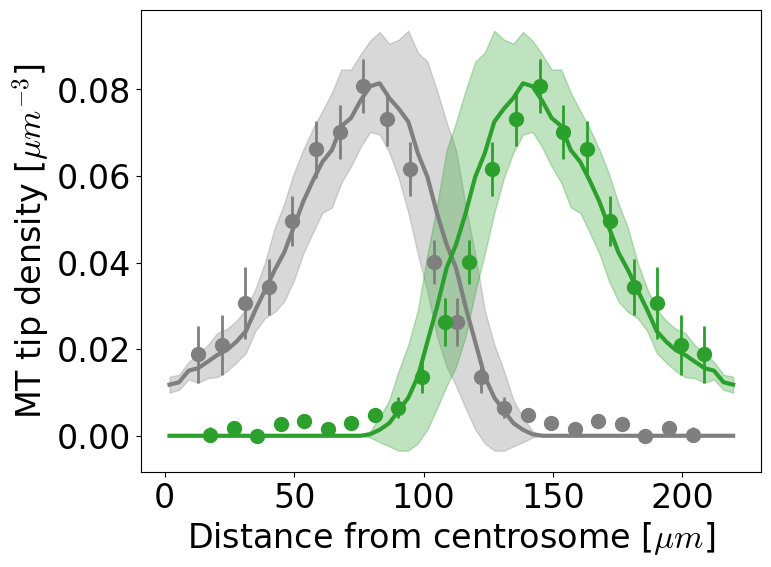

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Get centrosome positions to align experimental and simulated data
cent0_pos, cent1_pos = get_cent_pos(Path('../examples/unstable_3d_asters'))

# load data from csv
data = np.loadtxt("Unstable_3d_simulations_profile.csv", delimiter=",", skiprows=1)

# Plot simulation data
_ = ax.plot(data[:, 1], data[:, 3], label="Mean", lw=3, color="tab:grey")
plot_confidence_interval(
    ax,
    data[:, 1],
    data[:, 3],
    data[:, 4],
    6,
    color="tab:grey",
)
_ = ax.plot(cent1_pos[0] - cent0_pos[0] - data[:, 1], data[:, 3], label="Mean", lw=3, color="tab:green")
plot_confidence_interval(
    ax,
    cent1_pos[0] - cent0_pos[0] - data[:, 1],
    data[:, 3],
    data[:, 4],
    6,
    color="tab:green",
)

# Plot experimental data
_ = ax.errorbar(
    unstable_exp_data[:, 0] - cent0_pos[0],
    unstable_exp_data[:, 1],
    unstable_exp_data[:, 2],
    marker="o",
    linestyle="",
    c="tab:grey",
)
_ = ax.errorbar(
    -unstable_exp_data[:, 0] + cent1_pos[0],
    unstable_exp_data[:, 1],
    unstable_exp_data[:, 2],
    marker="o",
    linestyle="",
    c="tab:green",
)
_ = ax.set_xlabel(r"Distance from centrosome [$\mu m$]")
_ = ax.set_ylabel(r"MT tip density [$\mu m^{-3}$]")          


# Stable 3D aster simulation analysis

In [10]:
t_ind = int(-1 * 6)
bounds = [45, 10, 10]
bins = 30
window = 6

## Analyze raw data from simulations

In [ ]:
# Current best data set
dp_list = list(stable_sim_batch_path.glob('*/*.h5'))
if len(dp_list) < 2:
    raise StopIteration("Exiting cell lack of data to analyze. Please make sure the stable_sim_batch_path is set correctly and contains multiple directories with raw .h5 data files.")
fig, axarr = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

(mean, std, x_data, _1, _2, _3) = compare_theory_plots(fig, axarr, dp_list, t_ind, bounds, bins, window=window)
data = [["", "x", "sigmax", "eb1", "erroreb1[:,0]"],
        list(range(len(x_data))), 
        x_data.tolist(),  
        [0]*len(x_data), 
        mean.tolist(), 
        std.tolist()]

# Combine data into a single array
data = np.column_stack((np.arange(x_data.shape[0]), x_data, np.zeros(x_data.shape[0]), mean, std))

# Define column headers
headers = ',x,sigmax,eb1,"erroreb1[:,0]"'

# Save to CSV
np.savetxt("Stable_3d_simulations_profile.csv", data, delimiter=",", header=headers, comments="", fmt="%d,%f,%f,%f,%f")

# Plot analyzed data

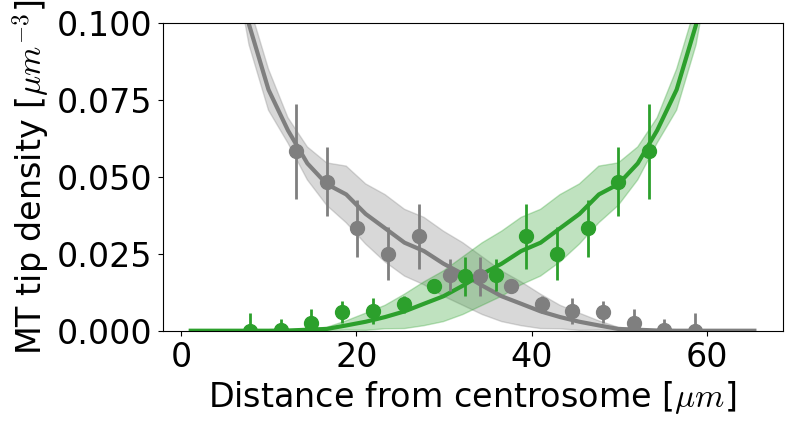

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# Get centrosome positions to align experimental and simulated data
cent0_pos, cent1_pos = get_cent_pos(Path('../examples/stable_3d_asters'))

# load data from csv
data = np.loadtxt("Stable_3d_simulations_profile.csv", delimiter=",", skiprows=1)

_ = ax.plot(data[:, 1], data[:, 3], label="Mean", lw=3, color="tab:grey")
plot_confidence_interval(
    ax,
    data[:, 1],
    data[:, 3],
    data[:, 4],
    6,
    color="tab:grey",
)
_ = ax.plot(cent1_pos[0] - cent0_pos[0] - data[:, 1], data[:, 3], label="Mean", lw=3, color="tab:green")
plot_confidence_interval(
    ax,
    cent1_pos[0] - cent0_pos[0] - data[:, 1],
    data[:, 3],
    data[:, 4],
    6,
    color="tab:green",
)

_ = ax.errorbar(
    stable_exp_data[:, 0] - cent0_pos[0],
    stable_exp_data[:, 1],
    stable_exp_data[:, 2],
    marker="o",
    linestyle="",
    c="tab:grey",
)
_ = ax.errorbar(
    -stable_exp_data[:, 0] + cent1_pos[0],
    stable_exp_data[:, 1],
    stable_exp_data[:, 2],
    marker="o",
    linestyle="",
    c="tab:green",
)
_ = ax.set_ylim(0, 0.10)
_ = ax.set_xlabel(r"Distance from centrosome [$\mu m$]")
_ = ax.set_ylabel(r"MT tip density [$\mu m^{-3}$]")          
